In [28]:
import os, re, regex, emoji
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wordcloud

In [2]:
file_name = "whatsapp.txt"

# before opening file, get an estimate of filesize
file_stat = os.stat(file_name)
file_kb = file_stat.st_size/1024
file_mb = file_kb/1024
print(f'File Size - in KB: {file_kb:.2f}KB, in MB: {file_mb:.2f}MB')

File Size - in KB: 3329.79KB, in MB: 3.25MB


In [3]:
# read txt lines as list
file_content = []
with open(file_name) as f:
    file_content = f.readlines()

print(f"There are {len(file_content)} lines of text in the file")
for idx, line in enumerate(file_content[:5]): 
    print("="*5, f" Line {idx+1} ", "="*5, "\n", line.strip())

There are 56838 lines of text in the file
=====  Line 1  ===== 
 10/04/2023, 20:30 - +234 913 775 4356: Picture it in your mind 😂
=====  Line 2  ===== 
 And see the scenario u created 😂
=====  Line 3  ===== 
 RCB LCB Dan run go RB as cover 😂
=====  Line 4  ===== 
 Who go dey defence
=====  Line 5  ===== 
 10/04/2023, 20:30 - +234 902 420 4577: Not this season he ain't. He hasn't been the same since he tore his acl. Before then? Not a single epl defender could compete and in Europe not even 4 defenders were arguable that's his peak.


In [4]:
# break each line into a recognizable format
# user_identifier, date, chat 
chat_replacements = {"<Media omitted>": "<<MEDIA>>",
                        "\n": "<<NEWLINE>>"}
def process_chat_replacement(chat_line):
    for special_word, word_replacement in chat_replacements.items():
        if special_word in chat_line: 
            chat_line = chat_line.replace(special_word, word_replacement)
    return chat_line


chat_details = []
chat_start = "^[0-3][0-9]/[0-1][0-9]/2023, [0-2][0-9]:[0-5][0-9]"


chat_member = None
for idx, line in enumerate(file_content):
    is_new_chat = re.search(chat_start, line)
    if is_new_chat:
        if idx:
            chat_details.append([chat_date, chat_time, chat_member, chat_content])

        date_seg = line.find(",")
        chat_date = line[:date_seg].strip()

        time_seg = line.find("-")
        chat_time = line[date_seg+1:time_seg].strip()

        member_chat = line[time_seg+1:]
        chat_member_seg = member_chat.find(":")
        chat_member = member_chat[:chat_member_seg].strip()

        chat_content = member_chat[chat_member_seg+1:].lstrip()
        chat_content = process_chat_replacement(chat_content)
    else:
        clean_content = process_chat_replacement(line.lstrip())
        chat_content += clean_content

print(f"there are {len(chat_details)} chats")
chat_headers = ['chat_date', 'chat_time', 'chat_member', 'chat_content']
chat_df = pd.DataFrame(chat_details, columns=chat_headers)
chat_df.head()

there are 39998 chats


,chat_date,chat_time,chat_member,chat_content
0,10/04/2023,20:30,+234 913 775 4356,Picture it in your mind 😂<<NEWLINE>>And see th...
1,10/04/2023,20:30,+234 902 420 4577,Not this season he ain't. He hasn't been the s...
2,10/04/2023,20:31,+234 815 108 8455,No be vvd una dey talk about??🤌🏾😂<<NEWLINE>>
3,10/04/2023,20:31,+234 706 088 8599,"Sebi it happened last math nah, wey dem use Ar..."
4,10/04/2023,20:31,+234 902 420 4577,Difference in tactics? United don't even keep ...


In [5]:
# de-identify user_identifiers
print(f"There are {chat_df['chat_member'].nunique()} active group members")
user_deidentifiers = {chat_member: f"Member_{idx}" 
                     for idx, chat_member in enumerate(chat_df['chat_member'].unique())}

chat_df['chat_member'] = [user_deidentifiers[chat_member] for chat_member in chat_df['chat_member']]
chat_df.head()

There are 135 active group members


,chat_date,chat_time,chat_member,chat_content
0,10/04/2023,20:30,Member_0,Picture it in your mind 😂<<NEWLINE>>And see th...
1,10/04/2023,20:30,Member_1,Not this season he ain't. He hasn't been the s...
2,10/04/2023,20:31,Member_2,No be vvd una dey talk about??🤌🏾😂<<NEWLINE>>
3,10/04/2023,20:31,Member_3,"Sebi it happened last math nah, wey dem use Ar..."
4,10/04/2023,20:31,Member_1,Difference in tactics? United don't even keep ...


In [6]:
# de-identify chat - remove user_identifiers, phone numbers, bank account, emails
user_ids = {user_id.replace('+',"").replace(' ',''):user_id for user_id in user_deidentifiers.keys()}

phone_regex = "@[0-9]{8,14}"
tagged_members = []
chat_content_replacements = []
num_tagged_members = []

for chat_line in chat_df['chat_content']:
    tagged_member = None
    num_tagged_member = 0
    
    is_phone = re.search(phone_regex, chat_line)
    if is_phone:
        chat_line_phones = re.findall(phone_regex, chat_line)
        num_tagged_member = len(chat_line_phones)
        tagged_member = []
        for chat_line_phone in chat_line_phones:
            tagged_id = chat_line_phone.replace('@','')
            if tagged_id in user_ids:
                member_deidentifier = user_deidentifiers[user_ids[tagged_id]]
            else:
                member_deidentifier = f"Member_{len(user_deidentifiers)}"
                user_ids[tagged_id] = f"+{tagged_id}"
                user_deidentifiers[f"+{tagged_id}"] = member_deidentifier

                
            tagged_member.append(member_deidentifier)
            chat_line = chat_line.replace(chat_line_phone,"<<MEMBERTAG>>")

    chat_content_replacements.append(chat_line)
    num_tagged_members.append(num_tagged_member)
    tagged_members.append(tagged_member)
    
#update df
chat_df['chat_content'] = chat_content_replacements
chat_df['num_tagged_members'] = num_tagged_members
chat_df['tagged_members'] = tagged_members

chat_df[chat_df['num_tagged_members']>0].head()

,chat_date,chat_time,chat_member,chat_content,num_tagged_members,tagged_members
112,10/04/2023,21:40,Member_4,<<MEMBERTAG>> <<MEMBERTAG>> <<NEWLINE>>Good ni...,2,"[Member_8, Member_1]"
116,10/04/2023,22:00,Member_6,<<MEMBERTAG>> Getafe up next<<NEWLINE>>Another...,1,[Member_2]
137,11/04/2023,07:48,Member_15,<<MEMBERTAG>> I think it's time we get another...,1,[Member_3]
139,11/04/2023,08:14,Member_11,<<MEMBERTAG>> <<MEMBERTAG>> 😅🤌<<NEWLINE>>,2,"[Member_3, Member_15]"
482,12/04/2023,10:15,Member_15,<<MEMBERTAG>> <<MEMBERTAG>> <<MEMBERTAG>> 😂😂😂<...,3,"[Member_20, Member_10, Member_78]"


In [7]:
# preprocess date
# day of week, week of month, week of year
# quarter
def get_quarter(dt_month):
    quarter_ranges = {range(1,4):"Q_1",
                     range(4,7): "Q_2",
                     range(7,10):"Q_3",
                     range(10,13):"Q_4"}
    for q_range, q in quarter_ranges.items():
        if dt_month in q_range: return q
        
def get_month_week(dt_day):
    week_ranges = {range(1,8):"Wk_1",
                     range(8,15): "Wk_2",
                     range(15,22):"Wk_3",
                     range(22,32):"Wk_4"}
    for wk_range, wk in week_ranges.items():
        if dt_day in wk_range: return wk



date_details = [datetime.strptime(dt, '%d/%m/%Y') for dt in chat_df['chat_date']]

# day, month, year, quarter, month_name, week_of_month, week_of_year, day_of_week, is_weekend
more_date_details = [[dt.strftime('%d'), dt.strftime('%m'), dt.strftime('%Y'),
                     get_quarter(dt.month), dt.strftime('%B'), get_month_week(dt.day),
                     f"wk_{dt.isocalendar().week}", dt.strftime('%A'), 
                      "weekend" if dt.weekday() > 5 else "weekday"]
                     for dt in date_details]
dt_headers = ['day', 'month', 'year', 'quarter', 'month_name', 
              'week_of_month', 'week_of_year', 'day_of_week', 'is_weekend']
date_df = pd.DataFrame(more_date_details, columns=dt_headers)
date_df.head()

,day,month,year,quarter,month_name,week_of_month,week_of_year,day_of_week,is_weekend
0,10,04,2023,Q_2,April,Wk_2,wk_15,Monday,weekday
1,10,04,2023,Q_2,April,Wk_2,wk_15,Monday,weekday
2,10,04,2023,Q_2,April,Wk_2,wk_15,Monday,weekday
3,10,04,2023,Q_2,April,Wk_2,wk_15,Monday,weekday
4,10,04,2023,Q_2,April,Wk_2,wk_15,Monday,weekday


In [8]:
# preprocess time
def get_day_period(tm_hour):
    hour_ranges = {range(0,1):"midnight", range(1,4):"very early morning", range(4,7):"early morning",
                  range(7,10):"morning", range(10,11):"late morning", range(12,13):"midday", 
                   range(13,17):"afternoon", range(17,20):"evening", range(20,24):"night"}
    for hr_range, hr in hour_ranges.items():
        if tm_hour in hr_range: return hr

time_details = [datetime.strptime(tm, '%H:%M') for tm in chat_df['chat_time']]
# hour, minute, am/pm, early morning/morning/late morning/midday/afternoon/evening/late evening/night/late night
more_time_details = [[tm.strftime('%H'), tm.strftime('%M'), "AM" if tm.hour<12 else "PM",
                     get_day_period(tm.hour)] 
                     for tm in time_details]
tm_headers = ["hour", "minute", "is_am", "day_period"]
tm_df = pd.DataFrame(more_time_details, columns=tm_headers)
tm_df.head()

,hour,minute,is_am,day_period
0,20,30,PM,night
1,20,30,PM,night
2,20,31,PM,night
3,20,31,PM,night
4,20,31,PM,night


In [32]:
# preprocess chat
def remove_xters(txt):
    for special_xter in ["<<NEWLINE>>", "<<MEDIA>>", "<<MEMBERTAG>>"]:
        txt=txt.replace(special_xter,' ')
    return txt

def get_counts(chat):
    line_count = chat.count("<<NEWLINE>>")
    chat = remove_xters(chat)
    emoji_count = emoji.emoji_count(chat, unique=False)
    emojis = emoji.distinct_emoji_list(chat)
    for emj in emojis:
        chat = chat.replace(emj,"")
    word_count = len(chat.split())
    xter_count = len(chat)
    
    return [line_count, word_count, xter_count, emoji_count, emojis]
    
# line_count, word_count, xter_count, emoji_count, emojis
chat_details = [get_counts(chat) for chat in chat_df['chat_content']]
details_header = ['line_count', 'word_count', 'xter_count', 'emoji_count', 'emojis']
details_df = pd.DataFrame(chat_details, columns=details_header)
details_df.head()

,line_count,word_count,xter_count,emoji_count,emojis
0,4,23,108,3,[😂]
1,1,36,192,0,[]
2,1,7,31,2,"[🤌🏾, 😂]"
3,2,26,118,6,[😂]
4,1,12,71,0,[]


In [33]:
print(len(chat_df), len(date_df), len(tm_df), len(details_df))
df = pd.concat([chat_df, date_df, tm_df, details_df], axis=1, join='inner')
df.head()

39998 39998 39998 39998


,chat_date,chat_time,chat_member,chat_content,num_tagged_members,tagged_members,day,month,year,quarter,...,is_weekend,hour,minute,is_am,day_period,line_count,word_count,xter_count,emoji_count,emojis
0,10/04/2023,20:30,Member_0,Picture it in your mind 😂<<NEWLINE>>And see th...,0,None,10,04,2023,Q_2,...,weekday,20,30,PM,night,4,23,108,3,[😂]
1,10/04/2023,20:30,Member_1,Not this season he ain't. He hasn't been the s...,0,None,10,04,2023,Q_2,...,weekday,20,30,PM,night,1,36,192,0,[]
2,10/04/2023,20:31,Member_2,No be vvd una dey talk about??🤌🏾😂<<NEWLINE>>,0,None,10,04,2023,Q_2,...,weekday,20,31,PM,night,1,7,31,2,"[🤌🏾, 😂]"
3,10/04/2023,20:31,Member_3,"Sebi it happened last math nah, wey dem use Ar...",0,None,10,04,2023,Q_2,...,weekday,20,31,PM,night,2,26,118,6,[😂]
4,10/04/2023,20:31,Member_1,Difference in tactics? United don't even keep ...,0,None,10,04,2023,Q_2,...,weekday,20,31,PM,night,1,12,71,0,[]


In [11]:
# user analysis
# frequecy, verbosity, most tagged, most emojis, most stickers
# sns.countplot(data=df, x="chat_member")
# df['chat_member'].value_counts()[:5].plot(kind='barh')

# group chat
# most active day, # most active time
# most active time per day, most active day per month

666098


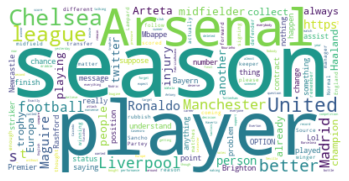

In [25]:
# visualizations
# word cloud
#Creating the text variable
all_chats = " ".join(df['chat_content'])


all_chats = [chat for chat in all_chats.split() if len(chat)>5]
all_chats = " ".join(all_chats)
print(len(all_chats))

# Creating word_cloud with text as argument in .generate() method
word_cloud = wordcloud.WordCloud(collocations = False, background_color = 'white').generate(all_chats)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# chat sentiment analysis

In [ ]:
# NLP, LLMs
# chat like my group people